In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from tqdm import tqdm
from sklearn.cluster import KMeans
from datasets import load_dataset

import os
from dotenv import load_dotenv

load_dotenv()

True

In [8]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
dataset = load_dataset("e1010101/tongue-images-384-segmented")

In [3]:
def extract_lab_features(image):
    image_np = np.array(image)
    
    # Convert the image to LAB color space
    lab_image = cv2.cvtColor(image_np, cv2.COLOR_BGR2LAB)
    
    # Create a mask for non-black pixels
    non_black_mask = np.any(image_np != [0, 0, 0], axis=-1)
    
    # Compute the mean LAB values, ignoring black pixels
    l_mean = np.mean(lab_image[:, :, 0][non_black_mask])
    a_mean = np.mean(lab_image[:, :, 1][non_black_mask])
    b_mean = np.mean(lab_image[:, :, 2][non_black_mask])
    
    return [l_mean, a_mean, b_mean]

In [4]:
features_train = []

In [5]:
for item in tqdm(dataset['train'], "preprocessing train images"):
    lab_features = extract_lab_features(item['image'])
    features_train.append(lab_features)

preprocessing train images: 100%|██████████| 619/619 [02:05<00:00,  4.92it/s]


In [6]:
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(features_train)
labels = kmeans.labels_

c:\Users\ezrat\anaconda3\envs\Project\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [7]:
features_array = np.array(features_train)

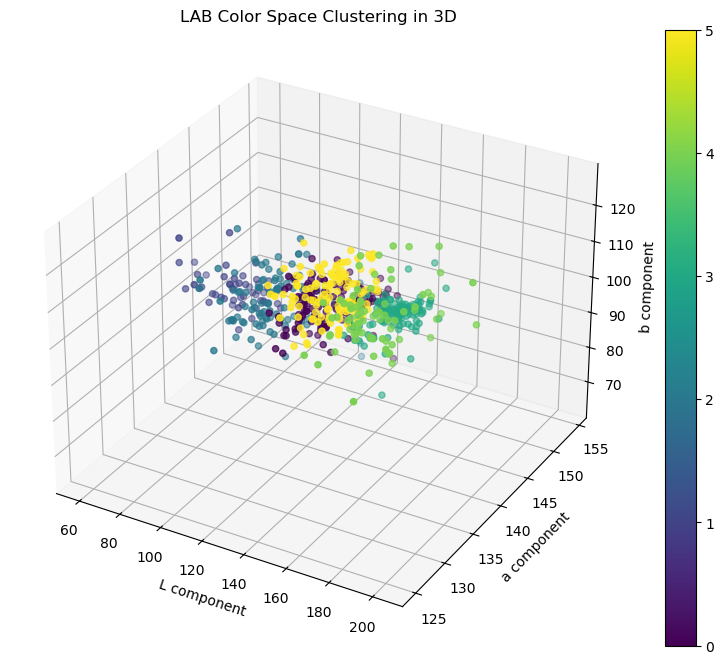

In [8]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(features_array[:, 0], 
                     features_array[:, 1], 
                     features_array[:, 2], 
                     c=labels, 
                     cmap='viridis')

# Set labels for each axis
ax.set_xlabel('L component')
ax.set_ylabel('a component')
ax.set_zlabel('b component')

# Set title
ax.set_title('LAB Color Space Clustering in 3D')

# Add a color bar
plt.colorbar(scatter)

# Show the plot
plt.show()

In [9]:
num_clusters = len(np.unique(labels))

# Initialize a list to hold average LAB values for each cluster
average_lab_values = []

for cluster_label in range(num_clusters):
    # Get indices of images in the current cluster
    cluster_indices = np.where(labels == cluster_label)[0]
    # Get the LAB features of images in the current cluster
    cluster_features = features_array[cluster_indices]
    # Compute the mean LAB values
    lab_mean = np.mean(cluster_features, axis=0)
    average_lab_values.append(lab_mean)
    print(f"Cluster {cluster_label}: Average LAB values = {lab_mean}")

Cluster 0: Average LAB values = [128.83910931 141.06871562  99.67468368]
Cluster 1: Average LAB values = [ 86.59189838 140.09305999  98.6323752 ]
Cluster 2: Average LAB values = [110.34010234 138.3716757  101.84201962]
Cluster 3: Average LAB values = [149.5997131  145.02269498  94.92224981]
Cluster 4: Average LAB values = [165.15321776 135.84206851 110.16023654]
Cluster 5: Average LAB values = [143.45807548 136.05712275 112.2119685 ]


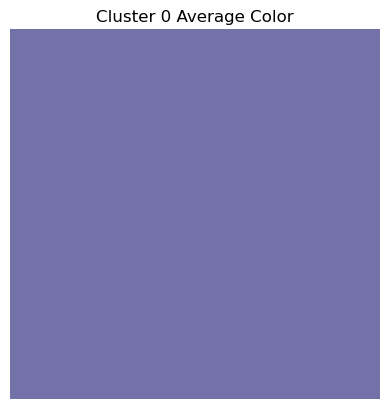

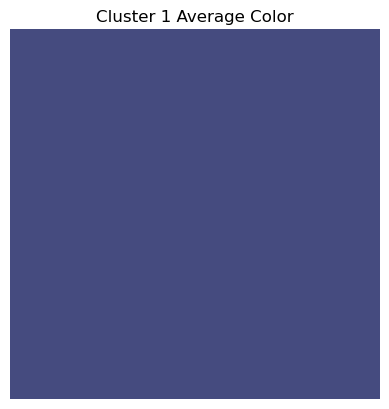

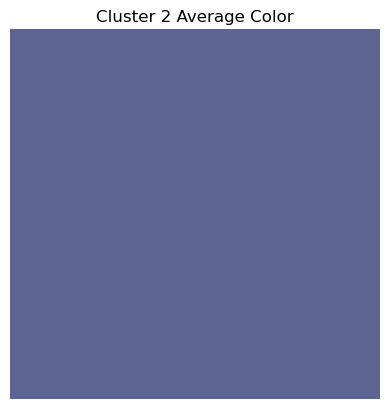

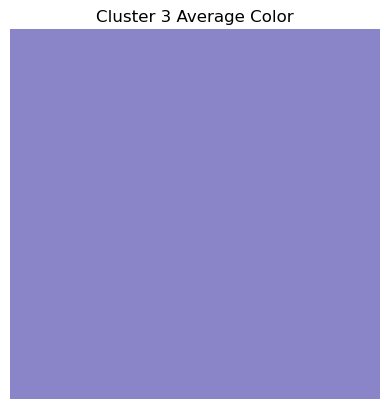

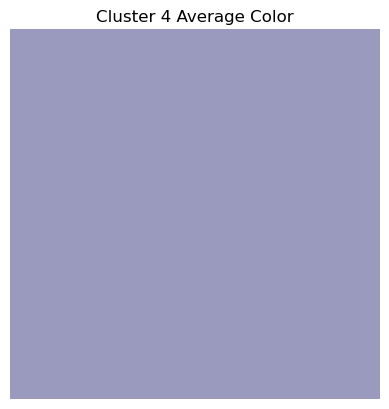

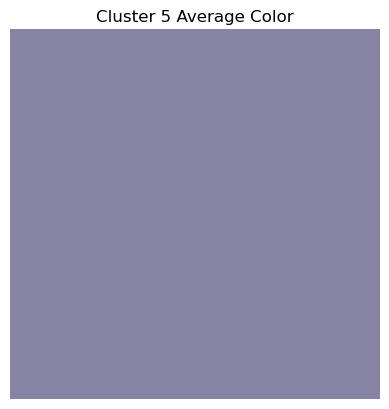

In [10]:
# Function to convert LAB to RGB and create a color patch
def lab_to_rgb_color_patch(lab_values):
    # Create a 1x1 pixel image with the average LAB color
    lab_color = np.zeros((1, 1, 3), dtype=np.uint8)
    lab_color[0, 0, :] = lab_values.astype(np.uint8)
    # Convert LAB to RGB using OpenCV
    rgb_color = cv2.cvtColor(lab_color, cv2.COLOR_LAB2RGB)
    # Ensure the values are in the valid range
    # rgb_color = np.clip(rgb_color, 0, 255)
    rgb_color = rgb_color.astype(np.uint8)
    # Convert to PIL Image for display
    color_patch = Image.fromarray(rgb_color.reshape(1, 1, 3))
    return color_patch

# Display the average color of each cluster
for cluster_label, lab_mean in enumerate(average_lab_values):
    # Convert the average LAB values to a color patch
    color_patch = lab_to_rgb_color_patch(lab_mean)
    # Resize the color patch for better visibility
    color_patch = color_patch.resize((100, 100))
    # Display the color patch
    plt.figure()
    plt.imshow(color_patch)
    plt.axis('off')
    plt.title(f'Cluster {cluster_label} Average Color')
    plt.show()

In [11]:
for cluster in range(num_clusters):
    os.makedirs(f'cluster_{cluster}', exist_ok=True)

# Iterate through the dataset and save images to appropriate directories
for idx, (item, label) in enumerate(zip(dataset['train'], labels)):
    image = item['image']
    cluster_dir = f'cluster_{label}'
    image.save(os.path.join(cluster_dir, f'image_{idx}.png'))

print("Images have been separated into cluster directories.")

Images have been separated into cluster directories.
